# Когда нейросети выигрывают -  TabNet

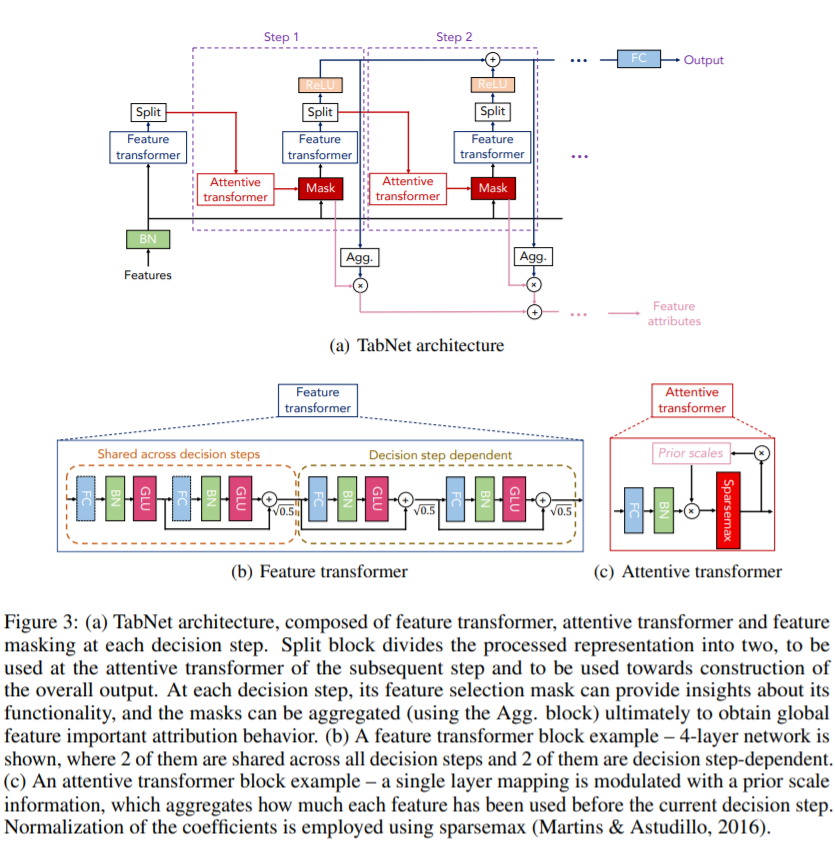

In [1]:
from IPython.display import Image
Image("figure1.png")

In [26]:
from time import time
import pandas as pd
import numpy as np
import scanpy
import anndata as ad
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import lightgbm as lgb
import torch
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor

## 1. Загрузка данных 

http://kaggle.com/datasets/alexandervc/scrnaseq-human-embryonic-stem-cell-under-nicotine

In [3]:
%%time
adata_ct = scanpy.read_10x_mtx('data/sc_rna_ct')
adata_nic = scanpy.read_10x_mtx('data/sc_rna_nic')
df_ct = adata_ct.to_df(layer=None)
df_nic = adata_nic.to_df(layer=None)
df_ct['group'] = 0
df_nic['group'] = 1
df = pd.concat([df_ct,df_nic])

CPU times: total: 45 s
Wall time: 45.5 s


In [4]:
df_ct.shape

(6847, 33695)

In [5]:
df_nic.shape

(5646, 33695)

## 1. Подготовка данных

In [6]:
df = df.loc[:, df.any()]

In [7]:
df.head()

,RP11-34P13.3,RP11-34P13.7,FO538757.3,FO538757.2,AP006222.2,RP4-669L17.2,RP4-669L17.10,RP5-857K21.4,RP11-206L10.9,FAM87B,...,MT-ND5,MT-ND6,MT-CYB,AC011043.1,AL592183.1,AC007325.4,AC007325.2,AC004556.1,AC240274.1,group
AAACCTGAGCGTAATA-1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,4.0,1.0,26.0,0.0,0.0,0.0,0.0,1.0,0.0,0
AAACCTGAGGCCCTCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.0,3.0,86.0,0.0,0.0,0.0,0.0,0.0,0.0,0
AAACCTGAGTTCGATC-1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,9.0,1.0,48.0,1.0,0.0,0.0,0.0,0.0,0.0,0
AAACCTGCAAAGGAAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0
AAACCTGCATAGAAAC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12493 entries, AAACCTGAGCGTAATA-1 to TTTGTCATCTCGATGA-1
Columns: 24323 entries, RP11-34P13.3 to group
dtypes: float32(24322), int64(1)
memory usage: 1.1+ GB


In [9]:
labels = df['group']

In [10]:
df = df.drop(columns=['group'])

In [11]:
X = df.values
y = labels.values

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=17)

## 3. Обучение модели

In [13]:
def confison_matrix_plot(cf_matrix):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap=['lightgray'])

In [14]:
%%time
deep_model = TabNetClassifier()  #TabNetRegressor()
deep_model.fit(
  X_train, y_train,
  eval_set=[(X_test, y_test)],
  max_epochs = 200,
  patience = 40,  
  eval_metric=['accuracy']
)

C:\Users\demet\miniconda3\envs\torch_vis\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.77363 | val_0_accuracy: 0.46025 |  0:00:14s
epoch 1  | loss: 0.71346 | val_0_accuracy: 0.55043 |  0:00:27s
epoch 2  | loss: 0.69245 | val_0_accuracy: 0.5699  |  0:00:43s
epoch 3  | loss: 0.68722 | val_0_accuracy: 0.56857 |  0:00:57s
epoch 4  | loss: 0.67923 | val_0_accuracy: 0.51788 |  0:01:10s
epoch 5  | loss: 0.67055 | val_0_accuracy: 0.52054 |  0:01:23s
epoch 6  | loss: 0.66453 | val_0_accuracy: 0.51227 |  0:01:36s
epoch 7  | loss: 0.65693 | val_0_accuracy: 0.53095 |  0:01:49s
epoch 8  | loss: 0.65195 | val_0_accuracy: 0.52054 |  0:02:02s
epoch 9  | loss: 0.64932 | val_0_accuracy: 0.53388 |  0:02:15s
epoch 10 | loss: 0.64495 | val_0_accuracy: 0.54456 |  0:02:28s
epoch 11 | loss: 0.64118 | val_0_accuracy: 0.53735 |  0:02:40s
epoch 12 | loss: 0.64236 | val_0_accuracy: 0.56297 |  0:02:53s
epoch 13 | loss: 0.63489 | val_0_accuracy: 0.54696 |  0:03:05s
epoch 14 | loss: 0.6296  | val_0_accuracy: 0.54829 |  0:03:18s
epoch 15 | loss: 0.62311 | val_0_accuracy: 0.56884 |  0

C:\Users\demet\miniconda3\envs\torch_vis\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


CPU times: total: 43min
Wall time: 24min 54s


In [28]:
%%time
y_pred = deep_model.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)

CPU times: total: 2min 57s
Wall time: 1min 31s


0.781


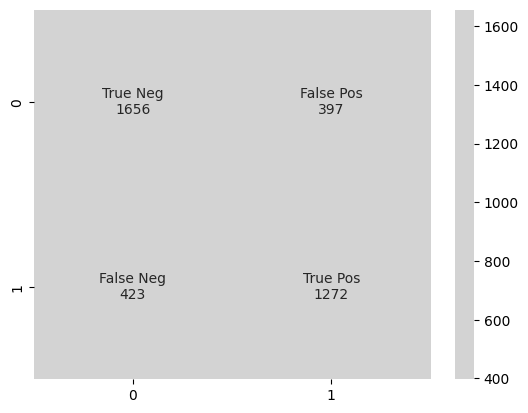

In [29]:
print(round(accuracy_score(y_pred, y_test),3))
confison_matrix_plot(cf_matrix)

## LightGBM

In [30]:
%%time
classic_model =  lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42,verbose=-1)
classic_model.fit(X_train, y_train)
y_pred = classic_model.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)

CPU times: total: 1min 2s
Wall time: 18.6 s


C:\Users\demet\miniconda3\envs\torch_vis\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



0.84


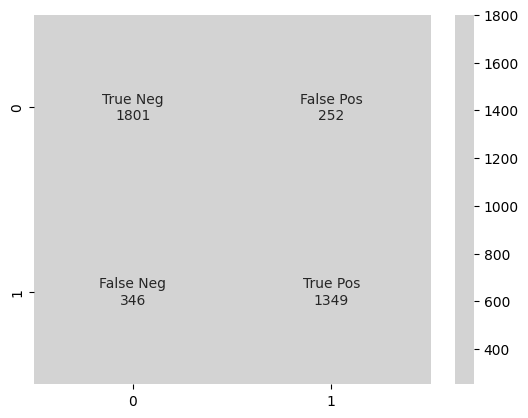

In [31]:
print(round(accuracy_score(y_pred, y_test),3))
confison_matrix_plot(cf_matrix)

# 4. Feature importance

## Global feature importance

In [20]:
feature_importances = pd.DataFrame()
feature_importances["feature"] = df.columns
feature_importances["importance"] = deep_model.feature_importances_


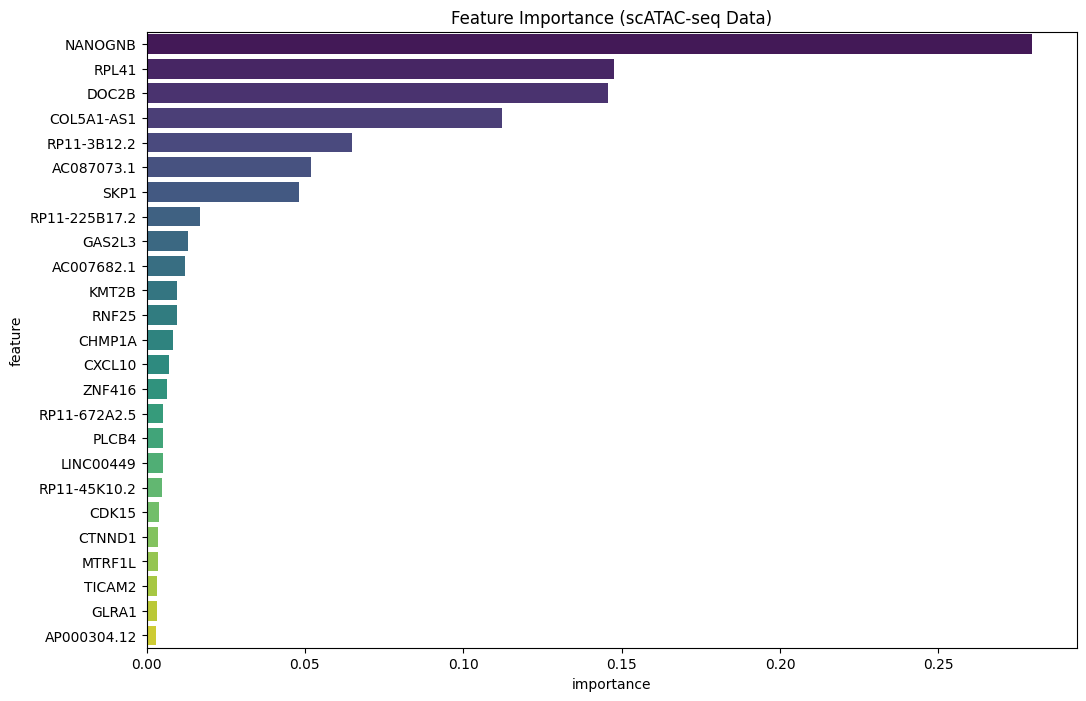

In [21]:
feature_importances.sort_values(
    by = "importance", 
    ascending = False, 
    inplace = True
)
plt.figure(figsize = (12, 8))
sns.barplot(y = feature_importances["feature"][:25], x = feature_importances["importance"][:25],hue = feature_importances["feature"][:25],
            palette = "viridis", legend=False)
plt.title("Feature Importance (scATAC-seq Data)")
plt.savefig("feat_imp_tb_atac.png", dpi = 100)
plt.show()

In [22]:
columns_to_select = feature_importances["feature"][:25]
explainability_matrix , masks = deep_model.explain(X_test)
# Normalize the importance by sample
normalized_explain_mat = np.divide(explainability_matrix, explainability_matrix.sum(axis=1).reshape(-1, 1)+1e-8)
# Add prediction to better understand correlation between features and predictions
val_preds = deep_model.predict(X_test)
explain_and_preds = np.hstack([normalized_explain_mat, val_preds.reshape(-1, 1)])
explain_df = pd.DataFrame(normalized_explain_mat, columns = df.columns)
explain_df_selected = explain_df[columns_to_select]
s = explain_df_selected.sum()
explain_df_sorted = explain_df_selected[s.sort_values(ascending=False).index[:]]

## Local feature importance

In [23]:
features =  columns_to_select
px.imshow(explain_df_sorted,
          labels=dict(x="Features", y="Samples", color="Importance"),
          x=features,
          title="Sample wise feature importance",
          color_continuous_scale='Jet',
          height=1000)